In [18]:
from IPython import display

import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn import set_config

set_config(display="diagram")

from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference,
    equalized_odds_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [2]:
cenapi = pd.read_csv("/Users/jorgeruizreyes/Documents/MSc Oxford/hilary/fairness-summative/models/output/cenapi.csv")

# TRAIN

In [3]:
target_variable = "found_status"
demographic = ["female"]
sensitive = ["female"]

In [4]:
Y, A = cenapi.loc[:, target_variable], cenapi.loc[:, sensitive]

In [5]:
X = pd.get_dummies(cenapi.drop(columns=[
    "female",
    "found_status"
]))

In [6]:
random_seed = 445
np.random.seed(random_seed)

In [7]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    cenapi,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

In [8]:
def resample_dataset(X_train, Y_train, A_train):
  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids), replace=True))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [9]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

In [46]:
unmitigated_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, penalty="l2"))

In [47]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [48]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

Text(0.5, 1.0, 'AUC logistic regression')

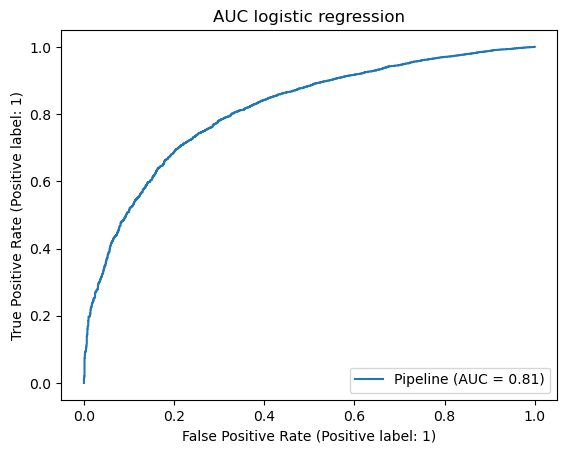

In [51]:
# Plot ROC curve of probabilistic predictions
RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test);
plt.title('AUC logistic regression')

In [45]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.651566432720953

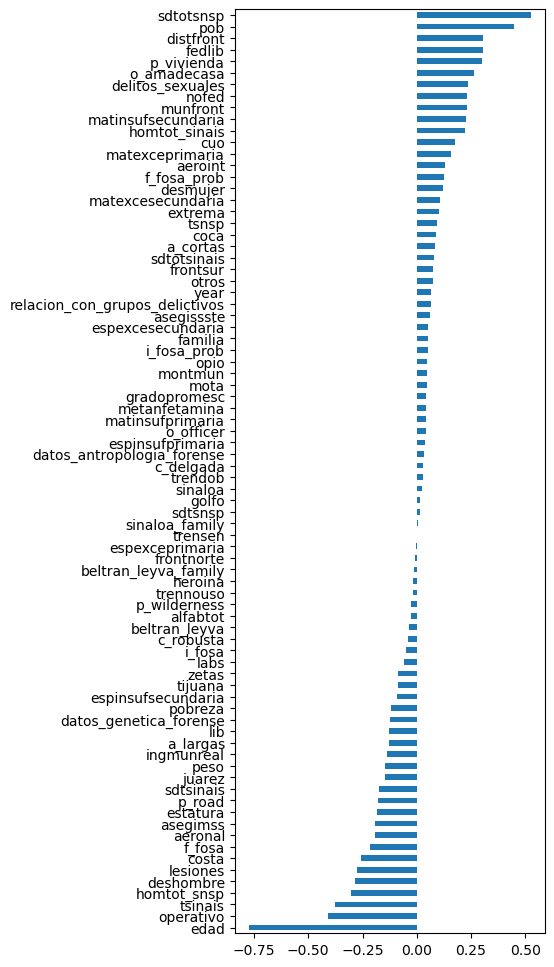

In [39]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logisticregression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

In [40]:
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['female'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
mf1.by_group

female
0   0.375
1   0.156
Name: false_negative_rate, dtype: float64

In [17]:
print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.218
ratio: 0.417
max across groups: 0.375


In [63]:
metrics_dict = {
    "false_negative_rate": false_negative_rate,
    "false_positive_rate": false_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['female'])

# The disaggregated metrics are then stored in a pandas DataFrame:
metricframe_unmitigated.by_group

,false_negative_rate,false_positive_rate,balanced_accuracy
female,,,
0,0.375,0.241,0.692
1,0.156,0.444,0.700


In [20]:
metricframe_unmitigated.difference()

selection_rate        0.256
false_negative_rate   0.218
false_positive_rate   0.203
balanced_accuracy     0.007
dtype: float64

In [21]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,false_positive_rate,balanced_accuracy
difference,0.256,0.218,0.203,0.007
ratio,0.695,0.417,0.542,0.989
group_min,0.582,0.156,0.241,0.692
group_max,0.838,0.375,0.444,0.700


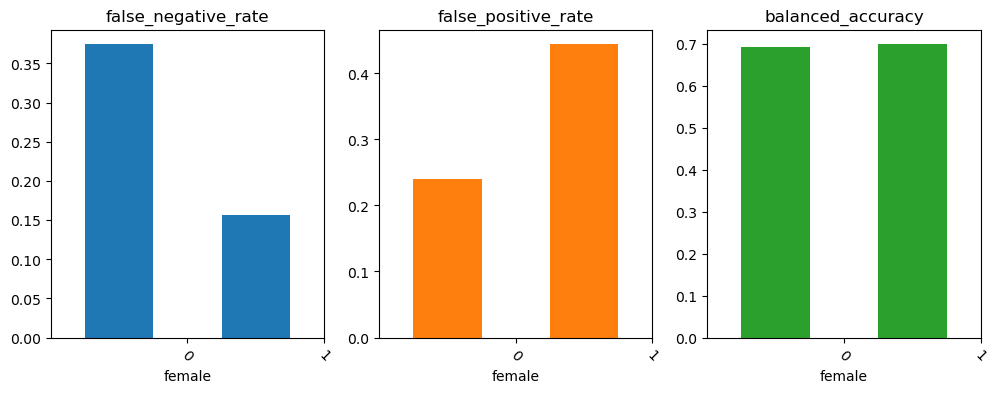

In [85]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);


# FIT SECOND MODEL

In [65]:
# Create your model here
clf = RandomForestClassifier()

# Fit the model to the training data
clf.fit(X_train_bal, Y_train_bal)
exercise_pred = clf.predict(X_test)

Text(0.5, 1.0, 'AUC random forest')

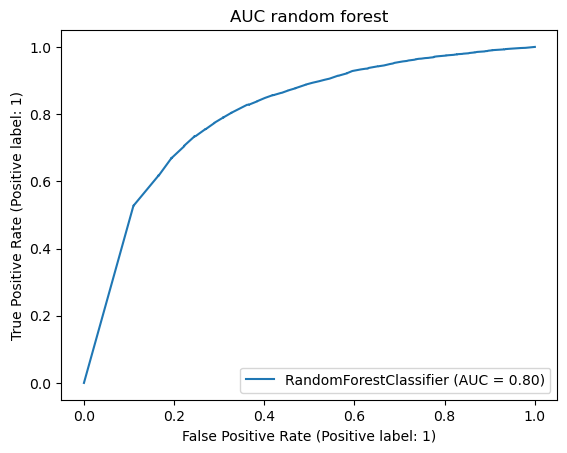

In [67]:
# Plot ROC curve of probabilistic predictions
RocCurveDisplay.from_estimator(clf, X_test, Y_test);
plt.title('AUC random forest')

In [68]:
prob_true, prob_pred = calibration_curve(Y_test, exercise_pred )

In [69]:
metricframe_exercise = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=exercise_pred,
    sensitive_features=df_test[["female"]]
)

In [70]:
metricframe_exercise.by_group

,false_negative_rate,false_positive_rate,balanced_accuracy
female,,,
0,0.055,0.738,0.604
1,0.020,0.815,0.583


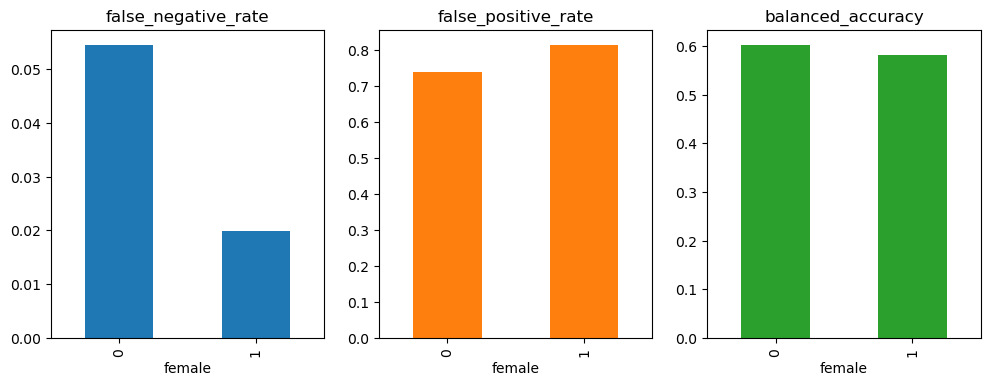

In [71]:
# Plot some of the performance disparities here
metricframe_exercise.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4),
                                       legend=False, rot=90, position=0.5);

# Mitigate

In [72]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [73]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [74]:
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

In [75]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1).T

female                                     0     1
Unmitigated        false_negative_rate 0.375 0.156
                   false_positive_rate 0.241 0.444
                   balanced_accuracy   0.692 0.700
ThresholdOptimizer false_negative_rate 0.299 0.289
                   false_positive_rate 0.315 0.327
                   balanced_accuracy   0.693 0.692

In [33]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,false_positive_rate,balanced_accuracy
Unmitigated: difference,0.256,0.218,0.203,0.007
ThresholdOptimizer: difference,0.048,0.010,0.013,0.002


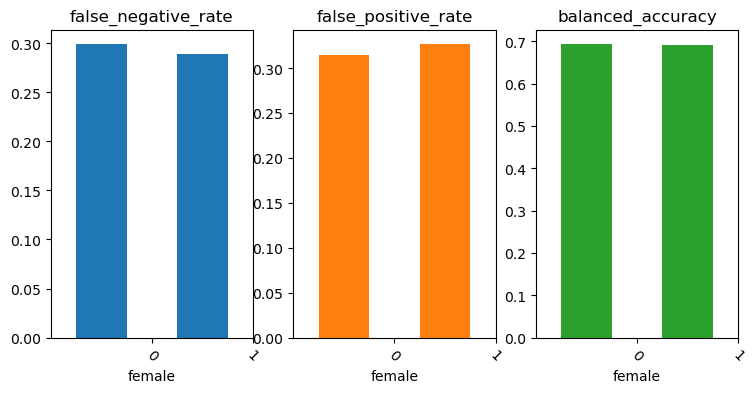

In [76]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,4], figsize=(12, 4), legend=False, rot=-45, position=1.5);

# Mitigate Rf 

In [77]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
postprocess_rf = ThresholdOptimizer(
    estimator=clf,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In [78]:
postprocess_rf.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=RandomForestClassifier(),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [79]:
Y_pred_postprocess_rf = postprocess_rf.predict(X_test, sensitive_features=A_test)

In [80]:
metricframe_postprocess_rf = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess_rf,
    sensitive_features=A_test
)

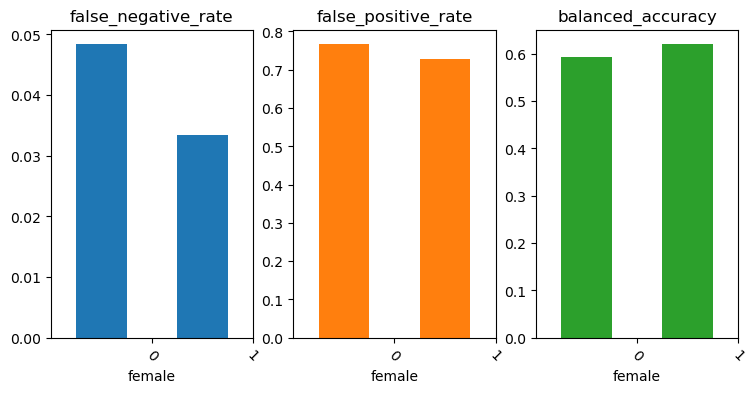

In [81]:
metricframe_postprocess_rf.by_group.plot.bar(subplots=True, layout=[1,4], figsize=(12, 4), legend=False, rot=-45, position=1.5);